## Project: Finding Donors for Charity using Machine Learning

### Getting Started

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
### Exploring the Data
Let's add code to load necessary Python libraries and load the census data. 

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Importing libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Importing supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Loading the Census dataset
data = pd.read_csv("census.csv")

# Success - Displaying the first five records
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. Let's compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = data['income'].count()

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:,.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [3]:
# Let's check all the features with its datatype

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
### Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Let's plot a histogram of these two features.

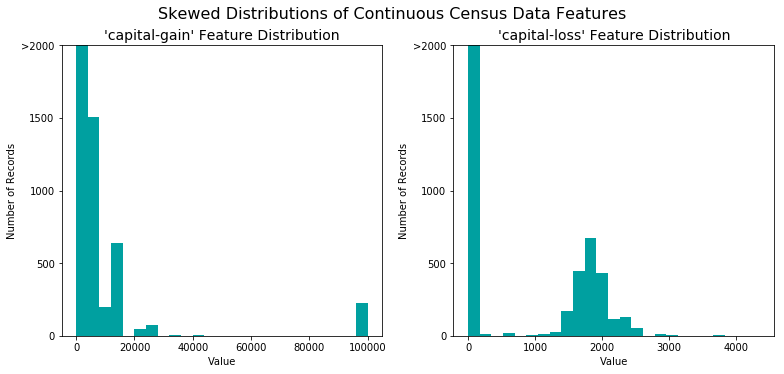

In [4]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualizing skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Let's perform a transformation on the data and visualize the results.

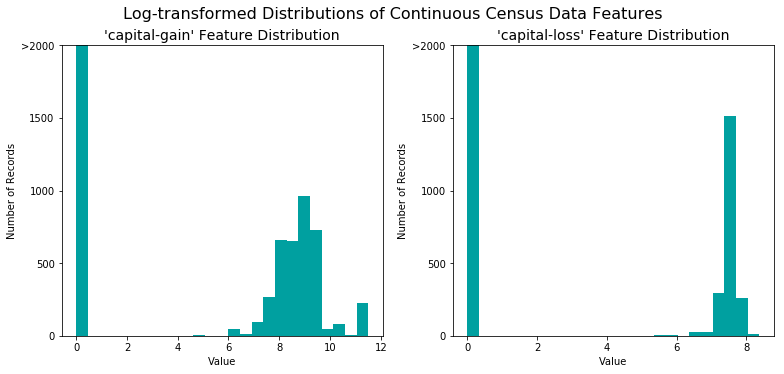

In [5]:
# Log-transforming the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Let's normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Importing sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Showing an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In [7]:
# One-hot encoding the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encoding the 'income_raw' data to numerical values
income = np.where(income_raw.values == '>50K', 1, 0)
# income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1 ) # Other way to achieve the same

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [8]:
print(income)

[0 0 0 ... 0 0 1]


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

# Splitting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Showing the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes i.e. those who make at most \$50,000 and those who make more, it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Let's have a recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives (words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall (sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam (including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam (all 10 false positives) and still get a reasonably good accuracy score. 

For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
What if we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [10]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
# FP = income.count() - TP
FP = np.size(income) - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculating accuracy, precision and recall
# Keeping original formulas even though values are Zero
accuracy  = (TP + TN) / (TP + FP + FN + TN)
recall    = TP / (TP + FN)
precision = TP / (TP + FP)
beta      = 0.5**2

# Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = ((1 + beta) * ((precision * recall) / ((beta * precision) + recall)))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
Let's use following supervised learning models that are currently available in [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) for this problem to test on the census data.

### 1. Logistic Regression

**Real world application:**

Logistic regression can be used to predict customer retention, such as a yes/no/maybe scenario indicating, whether a customer will re-visit/not visit again/may visit again based on the marketing stimuli.

**Strengths:**

1. It performs well when the dataset is linearly separable.
2. It is less prone to over-fitting but it can overfit in high dimensional datasets. 
3. Logistic regression is easier to implement, interpret and very efficient to train. 

**Weaknesses:**

1. Assumption of linearity between the dependent variable and the independent variables. In the real world, the data is rarely linearly separable.
2. If the number of observations are lesser than the number of features, Logistic Regression should not be used, otherwise it may lead to overfit.
3. It can only be used to predict discrete functions.

**Candidacy:**

As the prediction values are discrete (i.e. 0 or 1) in our problem, logistic regression is best suited to solve given problem


### 2. AdaBoost

**Real world application:**

AdaBoost is a powerful classification algorithm used in a wide variety of fields such as biology, computer vision, and speech processing.

**Strength:**

Adaboost is more robust than single estimators, have improved generalizability.
Simple models can be combined to build a complex model, which is computationally fast.

**Weaknesses:**

AdaBoost can be sensitive to noisy data and outliers
If we have a biased underlying classifier, it will lead to a biased boosted model.

**Candidacy:**

Adaboost is is considered to be high quality classifiers and the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

### 3. Gradient Boosting

**Real world application:**

The commercial web search engines Yahoo and Yandex use variants of gradient boosting in their machine-learned ranking engines.

**Strengths:**

1. It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise and it generalizes them with highly accurate results
2. Supports different loss function.
3. Works well with interactions.

**Weaknesses:**

1. Prone to over-fitting.
2. Requires careful tuning of different hyper-parameters

**Candidacy:**

Due to high accuracy in prediction and ensemble learning from weak prediction models, Gradient Boosting will surely help us to solve given problem i.e. predicting an individual who makes more than 50K.

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [11]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


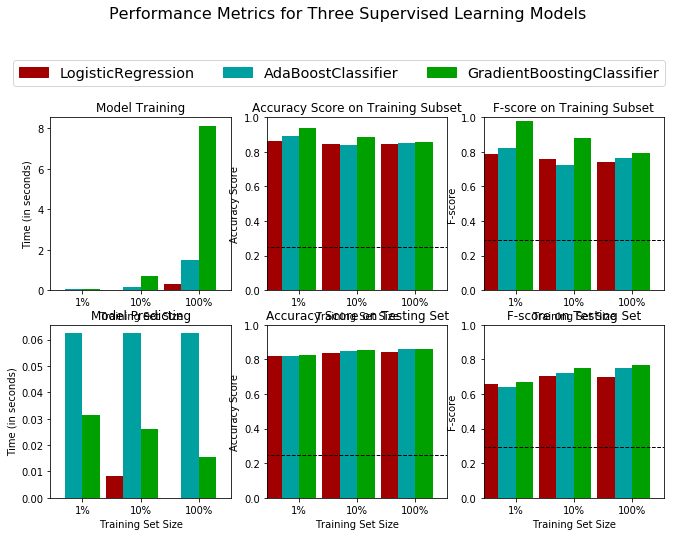

In [12]:
import visuals as vs

# Importing the supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initializing the three models
clf_A = LogisticRegression(random_state=44)
clf_B = AdaBoostClassifier(random_state=44)
clf_C = GradientBoostingClassifier(random_state=44)

# Calculating the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Running metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [13]:
# Printing out the values
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
acc_test,0.818684,0.838585,0.841902
acc_train,0.860000,0.846667,0.846667
f_test,0.656439,0.701667,0.701284
f_train,0.789286,0.757426,0.740826
pred_time,0.000000,0.008263,0.000000
train_time,0.000000,0.029072,0.288112


AdaBoostClassifier


,1%,10%,100%
acc_test,0.820674,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.641519,0.720497,0.751104
f_train,0.823643,0.721330,0.763350
pred_time,0.062502,0.062500,0.062493
train_time,0.062450,0.182745,1.498381


GradientBoostingClassifier


,1%,10%,100%
acc_test,0.827197,0.855943,0.863018
acc_train,0.940000,0.883333,0.856667
f_test,0.669473,0.750008,0.769098
f_train,0.980769,0.880051,0.794192
pred_time,0.031249,0.026031,0.015624
train_time,0.078122,0.725121,8.143156


----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

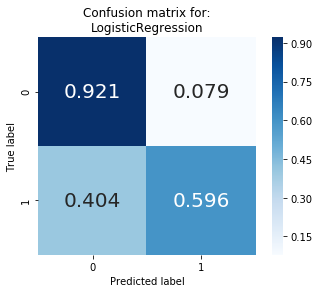

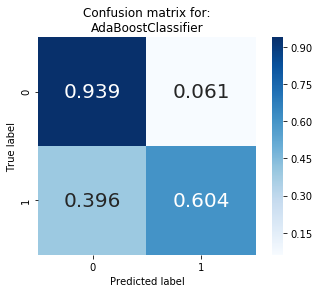

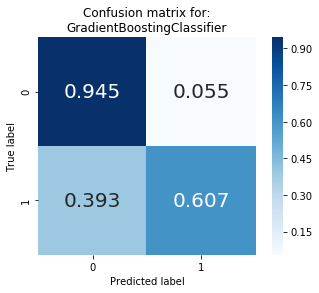

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":20}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

### Choosing the Best Model

By looking at the above results, Gradient Boosting Classifier is the most appropriate for the task of identifying individuals that make more than \$50,000. This is concluded by considering below mentioned points

1. If we compare the F score of Gradient boosting (i.e. 0.769098) with other two models i.e. AdaBoost (0.751104) and Linear regression (0.701284), it shows that Gradient Boosting outperformed the other two models. Also the above confusion matrix clearly states that the Gradient Boosting has the highest prediction accuracy. 
2. Prediction time is considerably low as compare to other models whereas the training time is bit higher to the other model.
3. Finally, as compare to other models Gradient Boosting is the best suitable for identifying individuals that make more than \$50,000 as it outperformed the other model in Prediction score, F-score and Accuracy.

### Describing the Model in Layman's Terms

**Ensemble learning:**

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. A machine learning ensemble consists of a finite set of alternative models, but typically allows for much more flexible structure to exist among those alternatives.

**Gradient boosting:**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model stage-wise like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

### Model Tuning
Now, using grid search (`GridSearchCV`) with different parameters & respective values, we will train the entire training set.

In [15]:
# Importing 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initializing the classifier
clf = GradientBoostingClassifier(n_estimators=500, random_state=44)

# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
              'max_depth' : [3, 5, 7],
              'n_estimators' :[25, 50, 150],
              'min_samples_split' : [3, 4, 5]
             }

# Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, cv=2, scoring=scorer)

# Fitting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Getting the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reporting the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8718
F-score on testing data: 0.7545

Optimized Model
------
Final accuracy score on the testing data: 0.8703
Final F-score on the testing data: 0.7507


In [16]:
best_clf = grid_fit.best_estimator_
print(best_clf)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=44,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8718      |     0.8718      |
| F-score        |       0.7545      |     0.7550      |


The Optimized model obtained the Accuracy Score of 0.8718 and F-Score of 0.7550.

The Optimized model's F-score is slightly better than the unpotimized model's F-score whereas Accuracy score is same for both the model.

As compared to the naive predictor benchmarks to new model we can say that, F-score increased from 0.2917 to 0.7550 and Accuracy increased from 0.2478 to 0.8718.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Observation
When **Exploring the Data**, we have seen that there are thirteen available features for each individual on record in the census data. Of these thirteen records, let us find five features that are we assume to be most important for prediction. 

**Education:** People those who have completed higher education will have better chances of having better paid jobs 

**Age:** Older people with more experience are surely getting paid well as compare to younger ones with less experience. Also as people gets old there are more chances that they may have more accumulated money.

**Occupation:** People with high position are surely being paid well

**Capital-gain:** This is surely an added advantage for an individual as it directly leads to the income. 

**Hours-per-week:** People those who work more hours per week are surely earning more than others

### Extracting Feature Importance

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


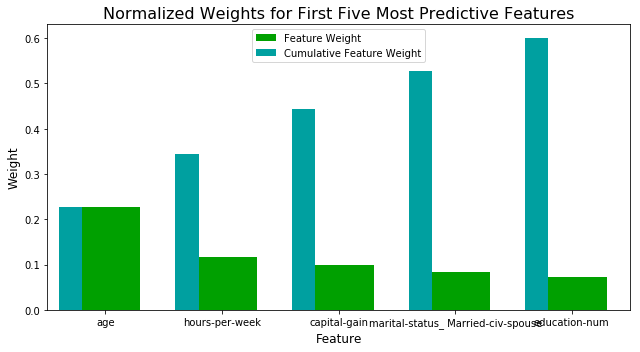

In [17]:
# Importing a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Training the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

As discussed earlier, Age, hours per week, capital gain and education-num (numeric value for education) are also considered by the Random Forest Classifier, as the most relevant features to predict an individual makes at most or above $50,000. Marital status which I have not considered to be the important feature seems that people those who are married and living together will have high cumulative income i.e. >50K

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [18]:
# Importing functionality for cloning a model
from sklearn.base import clone

# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8703
F-score on testing data: 0.7507

Final Model trained on reduced data
------
Accuracy on testing data: 0.8496
F-score on testing data: 0.7017


### Effects of Feature Selection
The final model's F-score and accuracy score on the reduced data is still more useful and suitable for prediction as compare to the model with all features. If the training time factor is more important for any use case, it is more worth to consider reduced data as training set instead of using all features.